# MLOceanEnsemble with drifters for the Basin


### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "k"
plt.rcParams["text.color"] = "k"
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["xtick.color"] = "k"
plt.rcParams["ytick.color"] = "k"

plt.rcParams["image.origin"] = "lower"

from importlib import reload

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress, DrifterPlotHelper, Observation
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL
from gpuocean.drifters import MLDrifterCollection, GPUDrifterCollection


In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 
from utils.BasinParameters import * 
from utils.BasinEnsembleInit import * 

## ML ensemble

In [6]:
ls = [6, 7, 8, 9]

In [9]:
Ne = [313,  84,  26,   6]

In [10]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [11]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [12]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [13]:
ML_ensemble = initMLensemble(Ne, args_list, data_args_list, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_timestep)


In [14]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)


from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

precomp_GC = []
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( MLEnKF.GCweights(obs_x, obs_y, r) )

In [15]:
truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args_list[-1])
init_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args)
init_mekl.perturbSim(truth)
truth.setKLModelError(**sim_model_error_basis_args)
truth.model_time_step = sim_model_error_timestep

In [16]:
# DA period
while MLOceanEnsemble.t < T_da:
    # Forward step
    MLOceanEnsemble.stepToObservation(MLOceanEnsemble.t + da_timestep)
    truth.dataAssimilationStep(truth.t + da_timestep)

    # DA step
    print("DA at ", MLOceanEnsemble.t)
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
    
    ML_state = copy.deepcopy(MLOceanEnsemble.download())

    for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
        Hx, Hy = MLOceanEnsemble.obsLoc2obsIdx(obs_x, obs_y)
        obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.multivariate_normal(np.zeros(3),np.diag(R))

        ML_state = MLEnKF.assimilate(ML_state, obs, obs_x, obs_y, R, 
                                r=r, obs_var=slice(1,3), relax_factor=relax_factor, 
                                min_localisation_level=min_location_level,
                                precomp_GC=precomp_GC[h])
        
    MLOceanEnsemble.upload(ML_state)


DA at  900.0
DA at  1800.0
DA at  2700.0
DA at  3600.0
DA at  4500.0
DA at  5400.0
DA at  6300.0
DA at  7200.0
DA at  8100.0
DA at  9000.0
DA at  9900.0
DA at  10800.0
DA at  11700.0
DA at  12600.0
DA at  13500.0
DA at  14400.0
DA at  15300.0
DA at  16200.0
DA at  17100.0
DA at  18000.0
DA at  18900.0
DA at  19800.0
DA at  20700.0
DA at  21600.0


In [17]:
T_forecast = 3600

In [19]:
while MLOceanEnsemble.t < T_da + T_forecast:
    truth.dataAssimilationStep(truth.t + da_timestep)
    MLOceanEnsemble.stepToObservation(MLOceanEnsemble.t + da_timestep)


In [20]:
MLstd = MLOceanEnsemble.estimate(np.std)    

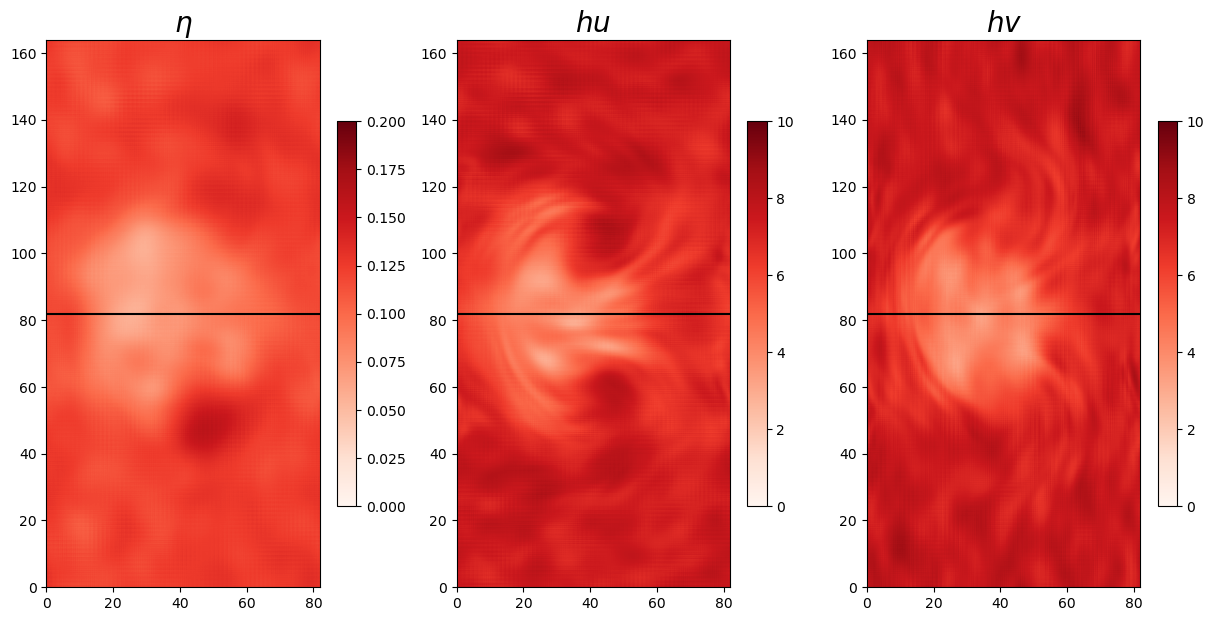

In [32]:
domain_extent = [0, args_list[-1]["nx"]*args_list[-1]["dx"]/1000, 0, args_list[-1]["ny"]*args_list[-1]["dy"]/1000]
fig, axs = imshow3var(MLstd, eta_vlim=0.2, huv_vlim=10, extent=domain_extent, ax_title_fontsize=20)
for i in range(3):
    axs[i].axhline(domain_extent[3]/2)